In [1]:
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import xarray as xr

In [2]:
def list_endpoints():
    base = 'https://coriolix.sikuliaq.alaska.edu/api/'
    response = requests.get(base)
    if response.status_code == requests.codes.ok:
        endpoints = response.json()
        return endpoints
    else:
        raise ConnectionError(response.reason)   

def get_sensor_info(sensor_id):
    base = 'https://coriolix.sikuliaq.alaska.edu/api/sensor/'
    params = {'sensor_id': sensor_id,
              'format': 'json'}
    response = requests.get(base, params = params)
    if response.status_code == requests.codes.ok:
        info = response.json()
        return info
    else:
        raise ConnectionError(response.reason)   

def get_parameter_info(sensor_id):
    base = 'https://coriolix.sikuliaq.alaska.edu/api/parameter/'
    params = {'sensor_id': sensor_id,
              'format': 'json'}
    response = requests.get(base, params = params)
    if response.status_code == requests.codes.ok:
        info = response.json()
        return info
    else:
        raise ConnectionError(response.reason)   


In [3]:
 def get_pco2(bdt: datetime, edt: datetime, decfac: int = 1, keep_flags = False):    
    base = 'https://coriolix.sikuliaq.alaska.edu/api/decimateData/'
    params = {'model': 'SensorFloat17',
              'decfactr': decfac,
              'date_0': bdt.strftime('%Y-%m-%d %H:%M:%S'),
              'date_1': edt.strftime('%Y-%m-%d %H:%M:%S'),
              'format':'json'}
    response = requests.get(base, params = params)
    if response.status_code == requests.codes.ok:
        data = response.json() # Read in data as a json.
        df = pd.DataFrame(data) # Convert to a pandas dataframe.
        df['time'] = pd.to_datetime(df.datetime_corrected).dt.tz_localize(None)  # Reformat time.
        df.index = df.time
        ds = df.to_xarray() # Convert to an xarray dataset.
        simple_rename = {'p4': 'cell_temperature',  # Update names to something that is more easily understood.
              'f4': 'flags_cell_temperature',
              'p3': 'co2',
              'f3': 'flags_co2',
              'p7': 'barometric_pressure',
              'f7': 'flags_barometric_pressure',
              'p6': 'flow_rate',
              'f6': 'flags_flow_rate',
              'p1': 'pco2',
              'f1': 'flags_pco2',
              'p2': 'sea_water_temperature',
              'f2': 'flags_sea_water_temperature',
              'p5': 'equilibration_temperature',
              'f5': 'flags_equilibration_temperature'}
        ds = ds.rename(simple_rename)
        
        vars_to_keep = list(simple_rename.values())  #Drop variables that were not renamed (Hint: they are empty).
        vars_to_drop = [v for v in ds.data_vars if v not in vars_to_keep]
        ds = ds.drop_vars(vars_to_drop, errors = 'ignore')
        
        if keep_flags is False:
            drops = [v for v in ds.data_vars if 'flag' in v]
            ds = ds.drop_vars(drops, errors = 'ignore')
        
    
        ds = ds.sortby('time')  # Sort the dataset.
        
        
        
        return ds
    else:
        raise ConnectionError(response.reason)   

In [4]:
def get_gps(bdt, edt, decfac: int = 15):    
    base = 'https://coriolix.sikuliaq.alaska.edu/api/decimateData/'
    params = {'model': 'GnssGgaBow',
              'decfactr': decfac,
              'date_0': bdt.strftime('%Y-%m-%d %H:%M:%S'),
              'date_1': edt.strftime('%Y-%m-%d %H:%M:%S'),
              'format':'json'}
    response = requests.get(base, params = params)
    if response.status_code == requests.codes.ok:
        data = response.json()        
        df = pd.DataFrame(data)
        df['time'] = pd.to_datetime(df.datetime_corrected).dt.tz_localize(None)
        df.index = df.time
        df = df[['latitude','longitude']]
        ds = df.to_xarray()
        
        ds = ds.sortby('time')
        
        return ds
    else:
        raise ConnectionError(response.reason)    

In [5]:
edt = datetime.now(timezone.utc)
bdt = edt - timedelta(days =  7)

In [6]:
pco2 = get_pco2(bdt, edt)

In [7]:
%%time
gps = get_gps(bdt, edt)

CPU times: user 459 ms, sys: 101 ms, total: 560 ms
Wall time: 49.5 s


In [8]:
gps

<xarray.Dataset>
Dimensions:    (time: 38891)
Coordinates:
  * time       (time) datetime64[ns] 2024-05-28T03:05:46.733800 ... 2024-06-0...
Data variables:
    latitude   (time) float64 60.1 60.1 60.1 60.1 ... 52.14 52.14 52.14 52.14
    longitude  (time) float64 -149.4 -149.4 -149.4 ... -144.6 -144.6 -144.6

In [9]:
ds = xr.combine_by_coords([gps, pco2])

In [10]:
dsr = ds.resample({'time': '30s'}).mean(skipna = True)
dsr = dsr.dropna(dim = 'time')

In [11]:
dsr

<xarray.Dataset>
Dimensions:                    (time: 2471)
Coordinates:
  * time                       (time) datetime64[ns] 2024-05-29T17:07:30 ... ...
Data variables:
    pco2                       (time) float64 0.0 447.2 106.2 ... 417.9 417.9
    sea_water_temperature      (time) float64 9.67 9.52 9.29 ... 7.82 7.83 7.83
    co2                        (time) float64 0.0 451.2 107.1 ... 437.7 437.7
    cell_temperature           (time) float64 24.87 25.62 26.32 ... 38.84 38.83
    equilibration_temperature  (time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    flow_rate                  (time) float64 69.8 65.86 62.44 ... 47.54 47.7
    barometric_pressure        (time) float64 1.016e+03 1.016e+03 ... 977.8
    latitude                   (time) float64 59.99 59.98 59.97 ... 52.14 52.14
    longitude                  (time) float64 -149.4 -149.4 ... -144.6 -144.6

Text(0.5, 0, 'Longitude')

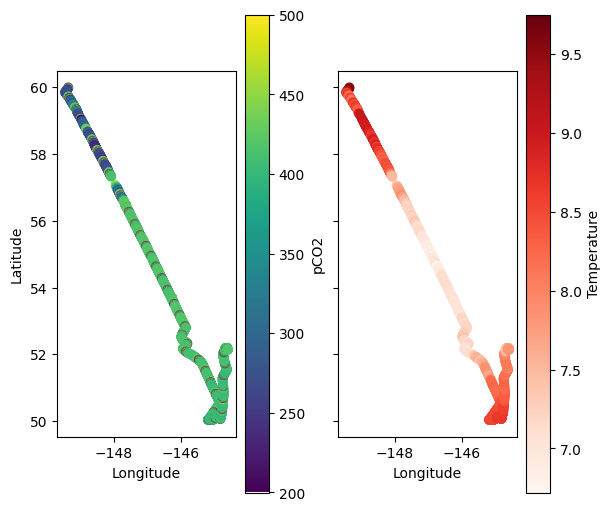

In [12]:
nrows = 1
ncols = 2
figsize = (6,5)

fig, ax = plt.subplots(nrows,ncols, figsize = figsize, constrained_layout = True, sharex = True, sharey = True)

p0 = ax[0].scatter(dsr.longitude, dsr.latitude, c = dsr.pco2, cmap = 'viridis', vmin = 200, vmax = 500)
p1 = ax[1].scatter(dsr.longitude, dsr.latitude, c = dsr.sea_water_temperature, cmap = 'Reds')

fig.colorbar(p0, ax = ax[0], label = 'pCO2')
fig.colorbar(p1, ax = ax[1], label = 'Temperature')

ax[0].set_box_aspect((dsr.latitude.max()-dsr.latitude.min())/(dsr.longitude.max()-dsr.longitude.min()))
ax[1].set_box_aspect((dsr.latitude.max()-dsr.latitude.min())/(dsr.longitude.max()-dsr.longitude.min()))

ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

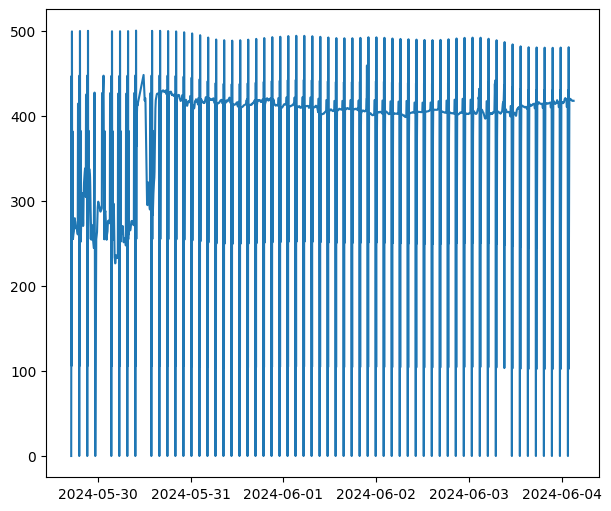

In [13]:
nrows = 1
ncols = 1
figsize = (6,5)

fig, ax = plt.subplots(nrows,ncols, figsize = figsize, constrained_layout = True, sharex = True, sharey = True)

ax.plot(dsr.time, dsr.pco2)


